# **Лабораторная работа 2:** применение SGD

Импортируем необходимые библиотеки:

In [22]:
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## **Математическая мотивировка**

Модель стохастического градиентного спуска имеет следующий математический вид:

Дано $n$ обучающих пар $(x_1, y_1), \ \ldots (x_n, y_n)$, $x_i \in \mathbb{R}^m, \ y_i \in \mathbb{R}$. Цель обучения – выучить линейную функцию вида $$y = w^Tx + b, \ w \in \mathbb{R}^m, \ b \in \mathbb{R}.$$

Суть метода заключается в минимизации регуляризованной ошибки обучения вида $$E(w, b) = \displaystyle \frac{1}{n} \sum_{i=1}^n L(y_i, f(x_i)) + \alpha R(w),$$

$L$ – функция потерь (loss), $R$ – член регуляризации (штраф), $\alpha$ – коэффициент силы регуляризации.

Веса обновляются по формуле $$w_{t+1} = w_t - \eta \cdot (\nabla L(w_t) + \alpha \nabla R(w_t)),$$

где $\eta$ – скорость обучения (learning rate).

## **Модель линейной регрессии SGDRegressor**

Загрузим данные для линейной регрессии из датасета `advertising_updated.csv`,который уже подвергся препроцессингу:

In [2]:
reg_data = pd.read_csv('advertising_updated.csv')
reg_data

,TV_scaled,radio_scaled,total_intersections_scaled,total_spent_scaled,TV^2_scaled,TV/radio_scaled,TV/newspaper_scaled,radio^2_scaled,radio/newspaper_scaled,TV_YJ_transformed,radio_YJ_transformed,total_intersections_YJ_transformed,total_spent_YJ_transformed,TV^2_YJ_transformed,TV/radio_YJ_transformed,TV/newspaper_YJ_transformed,radio^2_YJ_transformed,radio/newspaper_YJ_transformed,sales
0,0.969852,0.981522,2.596654,1.468851,0.940748,1.553389,2.330912,0.910534,1.914570,0.948674,0.962247,1.772062,1.401348,0.947699,1.328881,1.723421,0.960382,1.487903,22.1
1,-1.197376,1.082808,-0.251005,-0.775834,-1.057797,-0.519478,-0.533326,1.068102,1.013068,-1.191314,1.040179,0.289415,-0.735239,-1.190026,-0.200907,-0.285206,1.036827,1.123453,10.4
2,-1.516155,1.528463,-0.382561,-0.738099,-1.123849,-0.805658,-0.701070,1.834242,2.518661,-1.647757,1.370710,0.070170,-0.694548,-1.651777,-0.731909,-0.648552,1.360369,1.681129,9.3
3,0.052050,1.217855,1.312491,0.543808,-0.235412,0.825289,0.877761,1.287731,1.701084,0.141020,1.142387,1.363401,0.575267,0.143474,0.953953,1.047836,1.136989,1.411404,18.5
4,0.394182,-0.841614,-0.059563,0.529792,0.146386,-0.458687,1.226832,-0.877288,-0.207396,0.452715,-0.748651,0.523789,0.562286,0.454091,-0.117112,1.239616,-0.742218,0.273381,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.031031,0.832971,-0.506347,-0.103075,-0.256672,0.548577,-0.761533,0.690524,-0.653288,0.121376,0.845832,-0.229324,-0.042100,0.123886,0.783917,-0.827148,0.846063,-0.459484,17.3
189,-1.270941,-1.321031,-0.669827,-1.565032,-1.078228,-0.998998,-0.837902,-1.017553,-0.827040,-1.287908,-1.431436,-1.432687,-1.665173,-1.287349,-1.533475,-1.131377,-1.446653,-1.225311,7.6
190,-0.617035,-1.240003,-0.660090,-1.009790,-0.787483,-0.903471,-0.789356,-1.003493,-0.839194,-0.520949,-1.297017,-1.198884,-0.993652,-0.517571,-1.026553,-0.924562,-1.306279,-1.339412,9.7
191,0.349810,-0.942899,-0.623086,-0.087982,0.093070,-0.550128,-0.713247,-0.918366,-0.817996,0.413091,-0.875492,-0.772387,-0.027222,0.414623,-0.245805,-0.681610,-0.871443,-1.153008,12.8


Рассмотрим различный набор параметров:


*   `loss` -  функция потерь, которая определяет, как модель оценивает ошибку:
    
    ***squared_error***: используется, когда выбросов мало;

    ***huber***: устойчив к выбросам, полезен для шумных данных;

    ***epsilon_insensitive***: игнорирует малые отклонения в данных;

*   `penalty` - тип регуляризации, добавляемой к модели для предотвращения переобучения:

    **l2** : Ридж-регуляризация (сумма квадратов коэффициентов). Хорошо работает при наличии многих небольших признаков;

    **l1** :  Лассо-регуляризация (сумма модулей коэффициентов). Полезно для отбора признаков, так как обращает в ноль незначимые признаки;

    **elasticnet** : комбинация L1 и L2 регуляризаций.

In [3]:
X_reg = reg_data.loc[:, reg_data.columns != 'sales']
y_reg = reg_data['sales']

param_grid_reg = {
    'loss': ['squared_error', 'huber', 'epsilon_insensitive'],
    'penalty': ['l1', 'l2', 'elasticnet'],
}

Разобьем данные из датасета на обучающую и тестовую выборки (в нашем случае в соотношении 80% / 20%):


In [4]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

Используя GridSearchCV, определяем лучший набор гиперпараметров для модели регрессии:

In [5]:
sgd_reg = SGDRegressor(random_state=42)
grid_search_reg = GridSearchCV(sgd_reg, param_grid_reg)
grid_search_reg.fit(X_reg_train, y_reg_train)

# Лучшие параметры
print("Лучшие параметры для регрессии:", grid_search_reg.best_params_)

Лучшие параметры для регрессии: {'loss': 'epsilon_insensitive', 'penalty': 'l2'}


In [9]:
best_regressor = grid_search_reg.best_estimator_
y_ad_pred = best_regressor.predict(X_reg_test)
error = mae(y_reg_test, y_ad_pred)
print("Средняя абсолютная ошибка (MAE) на тестовой выборке:", round(error, 3))

Средняя абсолютная ошибка (MAE) на тестовой выборке: 0.287


Сравним различные архетектуры линейной регрессионной модели:

In [10]:
# Определение трех различных архитектур SGDRegressor
architectures = [
    {"type":"best", "par":{**grid_search_reg.best_params_}},  # Лучшая
    {"type":"middle", "par":{"loss": "squared_error", "penalty": "l1"}}, # Средняя
    {"type":"worst","par":{"loss": "huber", "penalty": "l1"}}   # Плохая
]

results = {"Type":[], "Architecture": [], "Train MAE": [], "Test MAE": []}

for idx, params in enumerate(architectures, 1):
    model = SGDRegressor(**params['par'], random_state=42)
    model.fit(X_reg_train, y_reg_train)

    y_train_pred = model.predict(X_reg_train)
    train_mae = mae(y_reg_train, y_train_pred)

    y_test_pred = model.predict(X_reg_test)
    test_mae = mae(y_reg_test, y_test_pred)

    results["Type"].append(params['type'])
    results["Architecture"].append(f"Arch {idx}")
    results["Train MAE"].append(round(train_mae, 3))
    results["Test MAE"].append(round(test_mae, 3))

print(pd.DataFrame(results))

     Type Architecture  Train MAE  Test MAE
0    best       Arch 1      0.336     0.287
1  middle       Arch 2      0.350     0.295
2   worst       Arch 3      9.950    11.398


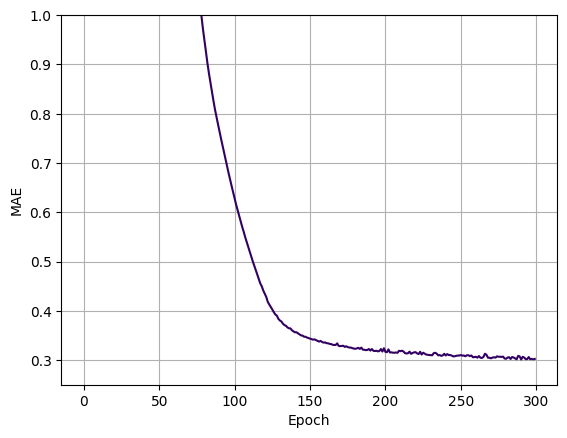

Средняя абсолютная ошибка (MAE) на тестовой выборке: 0.2893


/Users/djinja/Desktop/ML/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SGDRegressor was fitted without feature names
  warnings.warn(


In [14]:
sgd_reg_partial = SGDRegressor(**grid_search_reg.best_params_, random_state=42)

batch_size = 64
n_epochs = 300

X_reg_train_np = np.array(X_reg_train)
y_reg_train_np = np.array(y_reg_train)

error = []
for epoch in range(n_epochs):
    indices = np.arange(len(X_reg_train_np))
    np.random.shuffle(indices)
    X_reg_train_np = X_reg_train_np[indices]
    y_reg_train_np = y_reg_train_np[indices]

    for i in range(0, len(X_reg_train_np), batch_size):
        X_batch = X_reg_train_np[i:i + batch_size]
        y_batch = y_reg_train_np[i:i + batch_size]
        sgd_reg_partial.partial_fit(X_batch, y_batch)

    y_train_pred = sgd_reg_partial.predict(X_reg_train_np)
    train_mae = mae(y_reg_train_np, y_train_pred)
    error.append(train_mae)

plt.plot(error, color = "#310062")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid()
plt.ylim(0.25, 1)
plt.show()

y_ad_test_pred = sgd_reg_partial.predict(X_reg_test)
test_mae = mae(y_reg_test, y_ad_test_pred)
print(f"Средняя абсолютная ошибка (MAE) на тестовой выборке: {test_mae:.4f}")

### Выводы


Как видно из сравнения разных архитектур, результаты могут значительно меняться от разных гиперпараметров модели, таких как функция потерь и регуляризация. 

Существует влияние обучения по минибатчам: разбивка данных на небольшие порции для последовательного обновления модели позволяет не только повысить точность, но и ускорить процесс обучения.

## **Модель линейной классификации SGDClassifier**

Загрузим датасет для классификации `heart_updated.csv`, получившийся в ходе выполнения предыдущей лабораторной работы, и выполним аналогичные действия:

In [15]:
class_data = pd.read_csv('heart_updated.csv')
class_data

,age_scaled,sex_scaled,cp_scaled,trestbps_scaled,thalach_scaled,exang_scaled,oldpeak_scaled,slope_scaled,ca_scaled,thal_scaled,...,thal_YJ_transformed,cp/thalach_YJ_transformed,oldpeak/slope_YJ_transformed,exang/thal_YJ_transformed,ca/oldpeak_YJ_transformed,thalach/oldpeak/slope_YJ_transformed,log_age_YJ_transformed,log_trestbps_YJ_transformed,log_thalach_YJ_transformed,target
0,0.952197,0.681005,1.973123,0.763956,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873,...,-1.946718,1.147413,-1.069676,-0.689478,-0.657580,-1.181036,0.957521,0.831053,-0.079571,1
1,-1.915313,0.681005,1.002577,-0.092738,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922,...,-0.583232,1.072613,-1.069676,-0.689478,-0.657580,-1.181036,-1.833784,0.015387,1.863634,1
2,-1.474158,-1.468418,0.032031,-0.092738,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922,...,-0.583232,0.765144,1.336456,-0.689478,-0.657580,1.237773,-1.446289,0.015387,1.016397,1
3,0.180175,0.681005,0.032031,-0.663867,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922,...,-0.583232,0.778489,0.833820,-0.689478,-0.657580,0.962279,0.150298,-0.623201,1.345640,1
4,0.290464,-1.468418,-0.938515,-0.663867,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922,...,-0.583232,-1.051102,0.573965,1.393998,-0.657580,0.775146,0.263498,-0.623201,0.546831,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,0.290464,-1.468418,-0.938515,0.478391,-1.165281,1.435481,-0.724323,-0.649113,-0.714429,1.123029,...,1.176072,-1.051102,-0.618479,1.521267,-0.657580,-0.118286,0.263498,0.575627,-1.182579,0
279,-1.033002,0.681005,1.973123,-1.234996,-0.771706,-0.696631,0.138373,-0.649113,-0.714429,1.123029,...,1.176072,1.095660,0.573965,-0.689478,-0.657580,0.673588,-1.041091,-1.359643,-0.844774,0
280,1.503641,0.681005,-0.938515,0.706843,-0.378132,-0.696631,2.036303,-0.649113,1.244593,1.123029,...,1.176072,-1.051102,1.502221,-0.689478,1.785865,1.235300,1.553631,0.781167,-0.477062,0
281,0.290464,0.681005,-0.938515,-0.092738,-1.515125,1.435481,0.138373,-0.649113,0.265082,1.123029,...,1.176072,-1.051102,0.573965,1.521267,1.328262,0.608551,0.263498,0.015387,-1.457678,0


In [16]:
X_class = class_data.drop(columns=['target'])
y_class = class_data['target']
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

Проверим различные архитектуры (наборы гиперпараметров) классификатора и выберем лучший:

In [17]:
param_grid_clf = {
    'loss': ['perceptron', 'hinge', 'squared_hinge'],
    'penalty': ['l1', 'l2', 'elasticnet'],
}

In [20]:
sgd_clf = SGDClassifier(random_state=42)
grid_search_clf = GridSearchCV(sgd_clf, param_grid_clf, scoring='accuracy')
grid_search_clf.fit(X_class_train, y_class_train)

# Лучшие параметры
print("Лучшие параметры для классификации:", grid_search_clf.best_params_)

Лучшие параметры для классификации: {'loss': 'hinge', 'penalty': 'l1'}


In [21]:
best_classifier = grid_search_clf.best_estimator_
y_class_pred = best_classifier.predict(X_class_test)
accuracy = accuracy_score(y_class_test, y_class_pred)
print("Точность на тестовой выборке:", round(accuracy, 3))

Точность на тестовой выборке: 0.789


Составим тепловую карту параметра `accuracy` для тренировочных данных:

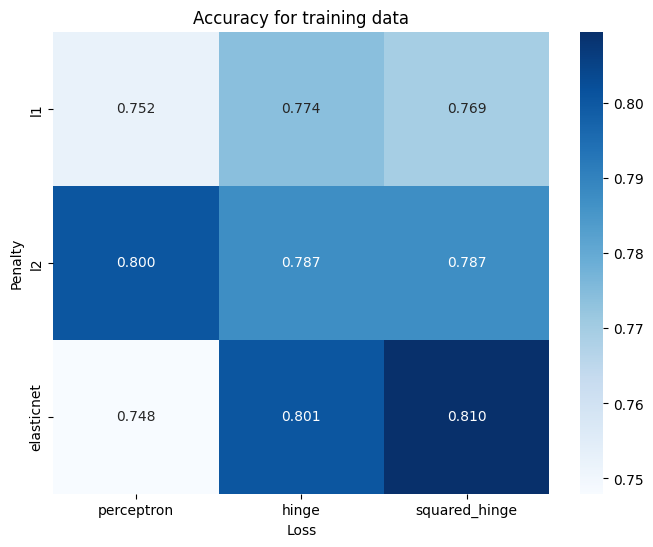

In [24]:
# Матрица для хранения результатов
accuracy_matrix = pd.DataFrame(index=param_grid_clf['penalty'], columns=param_grid_clf['loss'], dtype=float)

# Перебираем параметры и вычисляем accuracy с кросс-валидацией
for loss in param_grid_clf['loss']:
    for penalty in param_grid_clf['penalty']:
        try:
            model = SGDClassifier(loss=loss, penalty=penalty, random_state=42)
            scores = cross_val_score(model, X_class_train, y_class_train, cv=7, scoring='accuracy')
            accuracy_matrix.loc[penalty, loss] = scores.mean()
        except Exception as e:
            accuracy_matrix.loc[penalty, loss] = np.nan


# Визуализация
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt='.3f', cmap='Blues', cbar=True)
plt.title('Accuracy for training data')
plt.xlabel('Loss')
plt.ylabel('Penalty')
plt.show()

Составим тепловую карту параметра `accuracy` для тестовых данных:

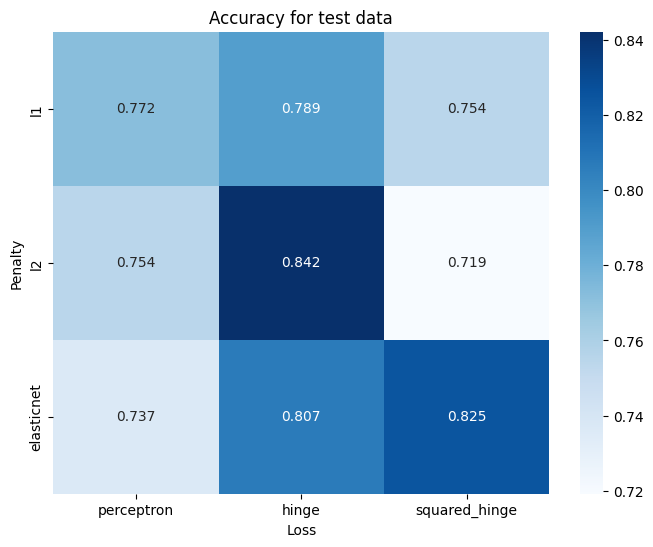

In [25]:
accuracy_matrix = pd.DataFrame(index=param_grid_clf['penalty'], columns=param_grid_clf['loss'], dtype=float)

for loss in param_grid_clf['loss']:
    for penalty in param_grid_clf['penalty']:
          model = SGDClassifier(loss = loss, penalty = penalty, random_state=42)
          model.fit(X_class_train, y_class_train)
          y_pred = model.predict(X_class_test)
          acc = accuracy_score(y_class_test, y_pred)
          accuracy_matrix.loc[penalty, loss] = acc

plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_matrix, annot=True, fmt='.3f', cmap='Blues', cbar=True)
plt.title('Accuracy for test data')
plt.xlabel('Loss')
plt.ylabel('Penalty')
plt.show()

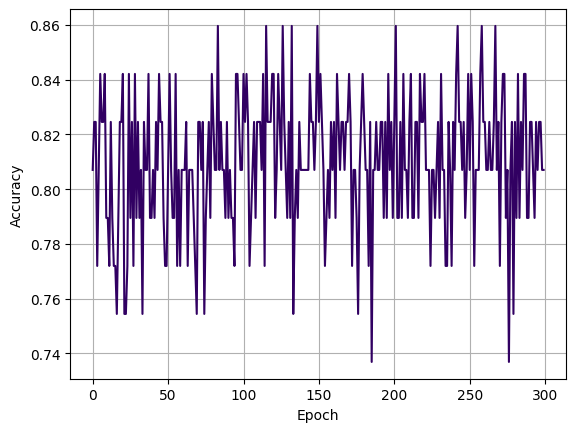

Точность на тестовой выборке: 0.8070


In [26]:
sgd_clf = SGDClassifier(**grid_search_clf.best_params_, random_state=42)

batch_size = 64  # Размер мини-выборки
n_epochs = 300  # Количество эпох
classes = y_class.unique()  # Уникальные классы в целевой переменной

# Мини-выборочная оптимизация
acc = []
for epoch in range(n_epochs):
    for start_idx in range(0, len(X_class_train), batch_size):
        end_idx = start_idx + batch_size
        X_batch = X_class_train.iloc[start_idx:end_idx]
        y_batch = y_class_train.iloc[start_idx:end_idx]

        # Обучаем модель на текущей мини-выборке
        sgd_clf.partial_fit(X_batch, y_batch, classes=classes)
    y_pred = sgd_clf.predict(X_class_test)
    acc.append(accuracy_score(y_class_test, y_pred))

# Оценка модели
plt.plot(acc, color = "#310062")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.grid()
plt.show()

y_pred = sgd_clf.predict(X_class_test)
accuracy = accuracy_score(y_class_test, y_pred)
print(f"Точность на тестовой выборке: {accuracy:.4f}")

### Выводы

Можно заметить, что лучший результат на тренировочных не может гарантировать лучший результат на тестовых данных, но если добавить батч-нормализацию, то результат значительно улучшается.